# Quick trending topic identification prototype: OCBC
Please bear in mind that this deliverable was done in a quick manner. There will be a few experiments/ways to achieve the goal. It can be done in a much more complicated way, such as topic modelling with full article content, using time series as another feature as well. In this approach I will only use headlines or titles to identify the trend. 

For this prototype, I assume that if I crawl from Google then it will be from the recent articles, so it will contain the most trending ones.

Because of time limited, I will use only K-means, Word Cloud and LDA to detect trending topics. I will try to do with BERT if I have more time.

# Using K Means clustering and Word Cloud

In [0]:
#Create a class to get latest news headlines
import bs4, sys
from bs4 import BeautifulSoup as soup
import urllib.request

class News():

        def __init__(self):
                self.texts = []
                self.links = []
                self.results = []

        def search(self, key):
                self.key = key
                #self.getpage()
                self.getfull()
        #Do not use this one because it won't return the full title but only truncated ones
        def getpage(self, page=1):
                self.user_agent='Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:64.0) Gecko/20100101 Firefox/64.0'
                self.headers={'User-Agent':self.user_agent}
                self.url="https://www.google.com/search?q="+self.key+"&tbm=nws&start=%d" % (20*(page-1)) 
                self.req=urllib.request.Request(self.url, headers=self.headers)
             
                self.response=urllib.request.urlopen(self.req)
        
                self.page=self.response.read()
                
                self.content=soup(self.page, "html.parser")
                #result=self.content.find(id="ires").find_all("div", class_="g")
                result=self.content.find_all("div", class_="g")
                for item in result:
                        self.texts.append(item.find("h3").text)
                        self.links.append(item.find("h3").find("a").get("href"))
                        self.results.append({'title':item.find("h3").text,'media':item.find("div", class_="slp").find_all("span")[0].text,'date':item.find("div", class_="slp").find_all("span")[2].text,'desc':item.find("div", class_="st").text,'link':item.find("h3").find("a").get("href"),'img':item.find("img").get("src")})
                self.response.close()
        #this function does getting full title
        def getfull(self):
            self.user_agent='Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:64.0) Gecko/20100101 Firefox/64.0'
            self.headers={'User-Agent':self.user_agent}
            self.url="https://news.google.com/search?q="+self.key
            self.req=urllib.request.Request(self.url, headers=self.headers)

            self.response=urllib.request.urlopen(self.req)

            self.page=self.response.read()

            self.content=soup(self.page, "html.parser")
            #result=self.content.find(id="ires").find_all("div", class_="g")
            result=self.content.find_all("article")
            for item in result:
                titles = item.find_all("h3")
                for title in titles:
                    self.texts.append(title.text)
            self.response.close()

        def gettext(self):
                return self.texts

        def getlink(self):
                return self.links

        def clear():
                self.texts = []
                self.links = []
                self.results = []

In [0]:
scrapper = News()

In [0]:
scrapper.search('OCBC')

In [0]:
import pandas as pd
pd.set_option('display.max_colwidth', -1) 
news_title = scrapper.gettext()

In [0]:
df = pd.DataFrame(news_title, columns = ['title_raw'])

In [66]:
df['title_raw'].head(10)

0    OCBC to Look to Private Bank for Next CEO?                                                 
1    Singapore Stocks Resilient Even if Trade Talks Fail, OCBC Says                             
2    OCBC looking from within for next CEO, Banking & Finance                                   
3    Stocks to watch: OCBC, Keppel Infra Trust, Kimly, Jumbo, mm2 Asia, United Global, Biolidics
4    OCBC to issue A$500m of senior floating-rate green notes due 2022                          
5    OCBC Profit Declines on Higher Provisions, Indonesia Charge                                
6    Experian API Enables Faster OCBC Account Opening                                           
7    Stocks to watch: Olam, SIIC Environment, Frasers Hospitality, MindChamps, OCBC             
8    SMFG, OCBC competing to buy majority stake in Indonesia's Bank Permata-sources             
9    OCBC to add Google Pay to real-time payments in Singapore by January 2020                  
Name: title_raw, dtype: object

In [0]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import re, spacy, gensim

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import calinski_harabaz_score

from collections import Counter
nltk.download('popular')

In [0]:
#stemmer = SnowballStemmer('english')
#tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [word for word in word_tokenize(text.lower())]

In [12]:
punc = ['.', '-', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%",'&','\'s']
stop_words = set(stopwords.words('english')).union(punc) 
desc = df['title_raw'].values
vectorizer = TfidfVectorizer(stop_words = stop_words, tokenizer=tokenize, min_df=2, max_df=0.5, max_features=100)
X = vectorizer.fit_transform(desc)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [13]:
word_features = vectorizer.get_feature_names()
print(len(word_features))
print(word_features)

100
['$', "'positive", '200', '2019', '2020', '6', 'add', 'ads', 'afternoon', 'all-in-one', 'app', 'asia', 'asian', 'asset', 'atm', 'australian', 'bank', 'banking', 'banks', 'beats', 'best', 'bid', 'bidding', 'black', 'briefing', 'buy', 'cards', 'ceo', 'charge', 'china', 'ching', 'citi', 'close', 'coal', 'codes', 'consumer', 'cyber', 'day', 'dbs', 'digital', 'financial', 'green', 'growth', 'hong', 'keppel', 'kong', 'majority', 'malaysia', 'market', 'markets', 'mobile', 'new', 'next', 'offer', 'optimistic', 'outlook', 'partners', 'payment', 'payments', 'permata', 'profit', 'provisions', 'q3', 'qr', 'quotes', 'rate', 'reit', 'resumes', 'revenue', 'says', 'scam', 'se', 'security', 'see', 'seeks', 'share', 'shares', 'singapore', 'singtel', 'slip', 'smfg', 'staff', 'stanchart', 'sti', 'stock', 'stocks', 'stories', 'taking', 'talks', 'team', 'tensions', 'terminals', 'thailand', 'top', 'trade', 'trust', 'using', 'voice', 'warns', 'watch']


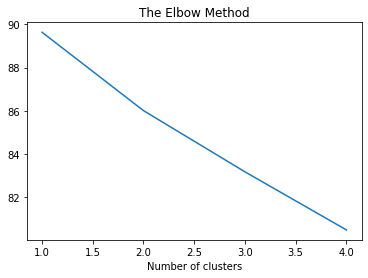

In [15]:
#Elbow Method to determine the number of clusters
from sklearn.cluster import KMeans
sse = []
for i in range(1,5):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=50,n_init=10,random_state=0)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
plt.plot(range(1,5),sse)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.savefig('elbow.png')
plt.show()

In [16]:
#With 2 clusters
kmeans = KMeans(n_clusters = 2, n_init = 20, n_jobs = 1) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(X)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=20, n_jobs=1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [17]:
common_words = kmeans.cluster_centers_.argsort()[:, ::-1]
#print(common_words[:,:20])
for num, centroid in enumerate(common_words[:,:20]):
    print(str(num) + ' : ' + ', '.join(word_features[word] for word in centroid))
clusters = kmeans.labels_.tolist()

#print(len(clusters))

0 : singapore, $, stocks, says, china, profit, banking, green, q3, hong, kong, outlook, 2020, watch, rate, charge, slip, asia, dbs, stock
1 : bank, singapore, permata, codes, qr, smfg, digital, buy, singtel, bidding, 'positive, citi, 2019, taking, staff, bid, coal, payment, payments, dbs


In [18]:
#With 4 clusters
kmeans = KMeans(n_clusters = 4, n_init = 20, n_jobs = 1) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(X)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=20, n_jobs=1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [23]:
common_words = kmeans.cluster_centers_.argsort()[:, ::-1]
#print(common_words[:,:20])
for num, centroid in enumerate(common_words[:,:17]):
    print(str(num) + ' : ' + ', '.join(word_features[word] for word in centroid))
clusters = kmeans.labels_.tolist()

#print(len(clusters))

0 : bank, permata, smfg, digital, buy, bidding, 'positive, citi, taking, staff, bid, dbs, partners, financial, trade, ceo, next
1 : singapore, says, bank, coal, payments, singtel, talks, china, codes, qr, add, using, reit, stock, watch, quotes, ads
2 : $, q3, banking, charge, stocks, profit, china, 2020, top, rate, 2019, sti, growth, share, green, consumer, outlook
3 : hong, kong, asia, se, tensions, slip, stocks, malaysia, optimistic, seeks, $, green, asian, see, markets, trust, keppel


In [0]:
#Assign each news title to its according cluster
#For example, cluster 2 is about consumer concern and outlook (growth) for Q3 as well as upcoming 2020
#Cluster 1: QR Code, singtel, and coal projects
#Cluster 0: CEO, bidding, revenue and permata
#Cluster 3: Stocks, loans, green notes and Hong Kong tensions
df['cluster'] = clusters

In [27]:
#The size of cluster 2 is the largest, therefore that topic is the most trending right now
df['cluster'].value_counts()


2    49
1    27
0    15
3    9 
Name: cluster, dtype: int64

In [0]:
#Display word cloud
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

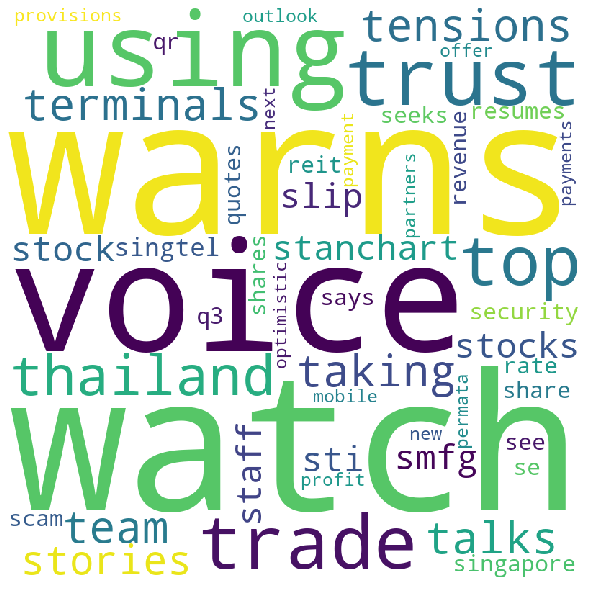

In [30]:
#The word cloud also shows us something that the clusters didn't detect because of its own metrics
#For example: Scam warns or OCBC uses Voice Assistant for their banking apps
w = WordCloud(width=800,height=800,background_color='white',max_words=50).fit_words(vectorizer.vocabulary_)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(w) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# Topic Extractions with LDA
In this part I use LDA (Latent Dirichlet Allocation) to see what percentage each news talks about each topic (distribution of topics among news_

A topic is represented as a weighted list of words.

![alt text](https://miro.medium.com/max/3916/0*uKkeYoh84QgWddJA.png)

In [0]:
#preprocess further
df['processed'] = df['title_raw'].str.lower().apply(word_tokenize)

In [0]:
def remove_stops(row):
    my_list = row['processed']
    meaningful_words = [w for w in my_list if not w in stop_words]
    return (meaningful_words)

df['processed'] = df.apply(remove_stops, axis=1)

In [0]:
from nltk import pos_tag

In [0]:
#lemmatizing according to its respected POS tags
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [0]:
texts = []
for row in df['processed']:
  texts.append(pos_tag(row))
df['POS_tokens'] = texts

In [48]:
#df['processed']= df['processed'].str.lower()
df['POS'] = ''
for i, row in enumerate(df['POS_tokens']):
  row_pos = []
  for el in row:
      d= lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1]))
      row_pos.append(d)
  df['POS'].loc[i] = row_pos


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [49]:
df

,title_raw,cluster,processed,POS_tokens,POS
0,OCBC to Look to Private Bank for Next CEO?,0,"[ocbc, look, private, bank, next, ceo]","[(ocbc, JJ), (look, VB), (private, JJ), (bank, NN), (next, IN), (ceo, NN)]","[ocbc, look, private, bank, next, ceo]"
1,"Singapore Stocks Resilient Even if Trade Talks Fail, OCBC Says",1,"[singapore, stocks, resilient, even, trade, talks, fail, ocbc, says]","[(singapore, RB), (stocks, NNS), (resilient, VBD), (even, RB), (trade, NN), (talks, NNS), (fail, VBP), (ocbc, NN), (says, VBZ)]","[singapore, stock, resilient, even, trade, talk, fail, ocbc, say]"
2,"OCBC looking from within for next CEO, Banking & Finance",2,"[ocbc, looking, within, next, ceo, banking, finance]","[(ocbc, NN), (looking, VBG), (within, IN), (next, JJ), (ceo, NN), (banking, NN), (finance, NN)]","[ocbc, look, within, next, ceo, banking, finance]"
3,"Stocks to watch: OCBC, Keppel Infra Trust, Kimly, Jumbo, mm2 Asia, United Global, Biolidics",3,"[stocks, watch, ocbc, keppel, infra, trust, kimly, jumbo, mm2, asia, united, global, biolidics]","[(stocks, NNS), (watch, VBP), (ocbc, IN), (keppel, NNP), (infra, NN), (trust, NN), (kimly, VB), (jumbo, JJ), (mm2, NN), (asia, NN), (united, VBD), (global, JJ), (biolidics, NNS)]","[stock, watch, ocbc, keppel, infra, trust, kimly, jumbo, mm2, asia, unite, global, biolidics]"
4,OCBC to issue A$500m of senior floating-rate green notes due 2022,2,"[ocbc, issue, $, 500m, senior, floating-rate, green, notes, due, 2022]","[(ocbc, JJ), (issue, NN), ($, $), (500m, CD), (senior, JJ), (floating-rate, JJ), (green, JJ), (notes, NNS), (due, JJ), (2022, CD)]","[ocbc, issue, $, 500m, senior, floating-rate, green, note, due, 2022]"
...,...,...,...,...,...
95,"Singapore stock watch: SPH Reit, Mapletree Logistics Trust, ISOTeam, Jumbo, Nordic, Tritech, Addvalue",1,"[singapore, stock, watch, sph, reit, mapletree, logistics, trust, isoteam, jumbo, nordic, tritech, addvalue]","[(singapore, NN), (stock, NN), (watch, NN), (sph, NN), (reit, NN), (mapletree, NN), (logistics, NNS), (trust, VBP), (isoteam, JJ), (jumbo, NN), (nordic, JJ), (tritech, NN), (addvalue, NN)]","[singapore, stock, watch, sph, reit, mapletree, logistics, trust, isoteam, jumbo, nordic, tritech, addvalue]"
96,"Singapore must build bridges, not walls: Heng Swee Keat at ST Global Outlook Forum",1,"[singapore, must, build, bridges, walls, heng, swee, keat, st, global, outlook, forum]","[(singapore, NN), (must, MD), (build, VB), (bridges, NNS), (walls, NNS), (heng, VBP), (swee, JJ), (keat, NN), (st, NN), (global, JJ), (outlook, NN), (forum, NN)]","[singapore, must, build, bridge, wall, heng, swee, keat, st, global, outlook, forum]"
97,OCBC and Rapyd team on instant mobile payments,2,"[ocbc, rapyd, team, instant, mobile, payments]","[(ocbc, NN), (rapyd, NN), (team, NN), (instant, NN), (mobile, NN), (payments, NNS)]","[ocbc, rapyd, team, instant, mobile, payment]"
98,"UnionBank, OCBC Bank tokenize remittances to Philippines",0,"[unionbank, ocbc, bank, tokenize, remittances, philippines]","[(unionbank, JJ), (ocbc, JJ), (bank, NN), (tokenize, NN), (remittances, NNS), (philippines, NNS)]","[unionbank, ocbc, bank, tokenize, remittance, philippine]"


In [0]:
from gensim.models import Phrases

In [51]:
#construct bigram model for the news headlines
tokens = df['POS'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
from gensim import corpora
from gensim import models

In [0]:
#Using LDA to detect different topics
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

In [59]:
np.random.seed(123456)
num_topics = 10
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

CPU times: user 177 ms, sys: 4.98 ms, total: 182 ms
Wall time: 184 ms


In [60]:
#see which topic talks about what
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.166*"slip" + 0.153*"hong_kong" + 0.144*"china" + 0.117*"market" + 0.086*"stock" + 0.078*"payment" + 0.050*"db" + 0.050*"look" + 0.050*"expand" + 0.050*"singapore_stock" + 0.028*"bank" + 0.014*"rate" + 0.000*"say" + 0.000*"2019" + 0.000*"bank_permata" + 0.000*"q3" + 0.000*"finance" + 0.000*"outlook" + 0.000*"asia" + 0.000*"talk"

1: 0.267*"$" + 0.196*"bank_permata" + 0.142*"green_loan" + 0.099*"smfg" + 0.071*"asia" + 0.071*"db" + 0.071*"profit" + 0.020*"charge" + 0.009*"slip" + 0.009*"best" + 0.009*"staff" + 0.009*"q3" + 0.009*"security" + 0.001*"outlook" + 0.001*"take" + 0.001*"expand" + 0.001*"2019" + 0.001*"market" + 0.001*"financial" + 0.001*"digital"

2: 0.277*"banking" + 0.211*"financial" + 0.157*"bank" + 0.148*"look" + 0.148*"consumer" + 0.023*"hong_kong" + 0.010*"say" + 0.001*"rate" + 0.001*"take" + 0.001*"db" + 0.001*"bank_permata" + 0.001*"q3" + 0.001*"green_loan" + 0.001*"outlook" + 0.001*"market" + 0.001*"slip" + 0.001*"digital" + 0.001*"expand" + 0.001*"china" + 0.001*

In [64]:
#Edit selected topic as below. Choose from topic 0 to 9 to see the distribution of important keywords
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
